In [107]:
%load_ext autoreload
%autoreload 2

from src.experiment import get_fallacy_df, RESPONSE_ERROR
from src.analysis import (
    get_sanity_check,
    add_classification_scores,
    get_macro_accuracies,
    add_llm_info,
    get_confusion_matrices,
    get_misclassifications,
    get_confusion_metrics,
)
from src.plot import plot_accuracies, plot_classification_confusion_matrix
from src.llms import LLM, LLMGroup
from src.fallacies import add_taxonomy
import seaborn as sns
import pandas as pd

sns.set_theme()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fallacy Classification Analysis

## Experiment 4: Fallacy Classification with zero-shot Prompt

In [108]:
df_fallacies_e4 = get_fallacy_df('data/fallacies_e4.csv')

# GPT-4 responses are incomplete and API usage is too expensive to get all responses.
# We use about 2300 input tokens per classification prompt, which means 5.336M tokens for 2320 samples.
# For classification with GPT-4 alone, the total cost would be $160.

# I also ran 135 classification prompts with o1-preview-2024-09-12. For each prompt, 2048 of about 2300 input tokens were cached,
# but the overall cost would still be way too high.

# https://openai.com/api/pricing/
# gpt-4:                    $30.00 / 1M tokens
# gpt-4o-mini-2024-07-18:   $0.150 / 1M input tokens
# gpt-4o-2024-08-06:        $2.50 / 1M input tokens
# o1-preview-2024-09-12:    $15.00 / 1M input tokens () 

df_fallacies_e4.drop(columns=['gpt_4_response', 'o1_preview_response'], inplace=True)

df_fallacies_e4.head()

[2024-11-06 12:05:42] Loaded existing fallacy dataframe from data/fallacies_e4.csv.


,step,entity,fallacy,label,category,subcategory,gpt_4o_response,gpt_4o_mini_response,claude_3_5_sonnet_response,claude_3_haiku_response,gemini_1_5_pro_response,gemini_1_5_flash_8b_response,mistral_large_2_response,mistral_small_2_response,llama_3_1_70b_response,llama_3_1_8b_response
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,Argument from Silence,Affirming the Consequent,Argument from Silence,Denying the Antecedent,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence.
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,Argument from Silence,Affirming the Consequent,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,(164) Argument from Silence,Argument from Silence,Argument from Silence.
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Appeal to Silence,Argument from Silence,Argument from Silence.
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,Argument from Silence,Appeal to Authority,Appeal to Authority,Appeal to Authority,Appeal to Authority,Appeal to Authority,Argument from Silence,Appeal to Authority,Argument from Silence,Argument from False Authority.
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence.


### Scoring and Sanity Check

In [109]:
add_classification_scores(df_fallacies_e4)

# Check completeness of responses, predictions and scores
df_fallacies_e4.replace(['', RESPONSE_ERROR], None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320 entries, 0 to 2319
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   step                          2320 non-null   object  
 1   entity                        2320 non-null   object  
 2   fallacy                       2320 non-null   category
 3   label                         2320 non-null   category
 4   category                      2320 non-null   category
 5   subcategory                   2320 non-null   category
 6   gpt_4o_response               2320 non-null   object  
 7   gpt_4o_mini_response          2320 non-null   object  
 8   claude_3_5_sonnet_response    2320 non-null   object  
 9   claude_3_haiku_response       2320 non-null   object  
 10  gemini_1_5_pro_response       2319 non-null   object  
 11  gemini_1_5_flash_8b_response  2320 non-null   object  
 12  mistral_large_2_response      2320 non-null   ob

In [110]:
get_sanity_check(df_fallacies_e4)

,response_length_mean,missing_responses,invalid_predictions
gpt_4o,20.5,0,72
gpt_4o_mini,20.9,0,47
claude_3_5_sonnet,20.8,0,68
claude_3_haiku,48.4,0,156
gemini_1_5_pro,19.8,1,47
gemini_1_5_flash_8b,20.6,0,254
mistral_large_2,21.9,0,56
mistral_small_2,23.5,0,123
llama_3_1_70b,29.4,2,60
llama_3_1_8b,28.6,0,24


### Overall Accuracies

In [111]:
_, df_subcategory_accuracies_e4, df_category_accuracies_e4, df_overall_accuracies_e4 = get_macro_accuracies(df_fallacies_e4)

In [112]:
df_overall_accuracies_e4 = df_overall_accuracies_e4.sort_values('accuracy', ascending=False)
df_overall_accuracies_e4.round(1)

,accuracy
gpt_4o,47.3
claude_3_5_sonnet,42.1
gemini_1_5_pro,41.5
llama_3_1_70b,28.4
mistral_large_2,25.8
gpt_4o_mini,24.2
gemini_1_5_flash_8b,18.8
claude_3_haiku,15.8
mistral_small_2,14.4
llama_3_1_8b,11.0


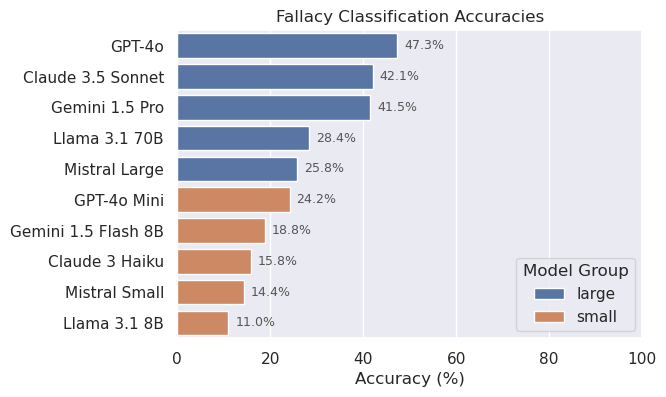

In [113]:
plot_accuracies(
    data=add_llm_info(df_overall_accuracies_e4),
    figsize=(6, 4),
    title='Fallacy Classification Accuracies',
    hue='llm_group',
    legend_title='Model Group',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    annotate=True,
)

- GPT-4o achieves best classification accuracy of 47.3%, even better than 35% achieved by GPT-4 (Hong et al., 2024).
- Lightweight LLMs perform worse, but still much better than the models tested by Hong et al. (2024).

### Category Accuracies

In [114]:
df_category_accuracies_e4.round(1)

category,formal,informal
gpt_4o,52.8,41.7
gpt_4o_mini,33.1,15.2
claude_3_5_sonnet,46.7,37.4
claude_3_haiku,16.0,15.5
gemini_1_5_pro,44.8,38.2
gemini_1_5_flash_8b,25.9,11.7
mistral_large_2,29.8,21.8
mistral_small_2,19.6,9.1
llama_3_1_70b,33.3,23.5
llama_3_1_8b,16.4,5.7


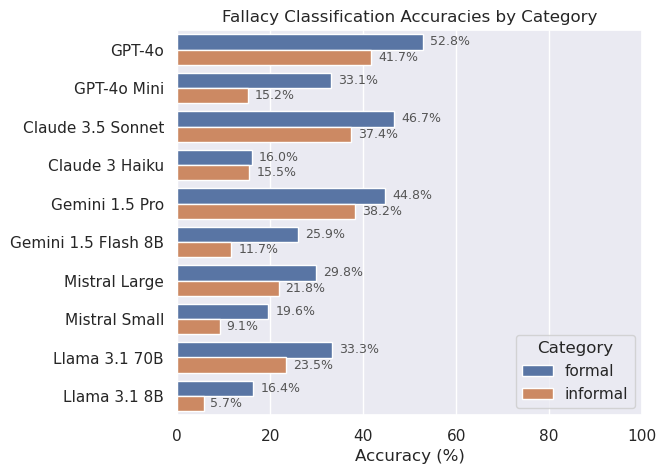

In [115]:
df_category_accuracies_long_e4 = pd.melt(df_category_accuracies_e4, var_name='category', value_name='accuracy',
                                         ignore_index=False)
plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e4),
    figsize=(6, 5),
    title='Fallacy Classification Accuracies by Category',
    hue='category',
    legend_title='Category',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    annotate=True,
)

In [116]:
df_plot = add_llm_info(df_category_accuracies_long_e4, group=True).groupby(
    ['llm_group', 'category'], observed=True).mean()
df_plot.round(1)

accuracy
llm_group category          
large     formal        41.5
          informal      32.5
small     formal        22.2
          informal      11.4

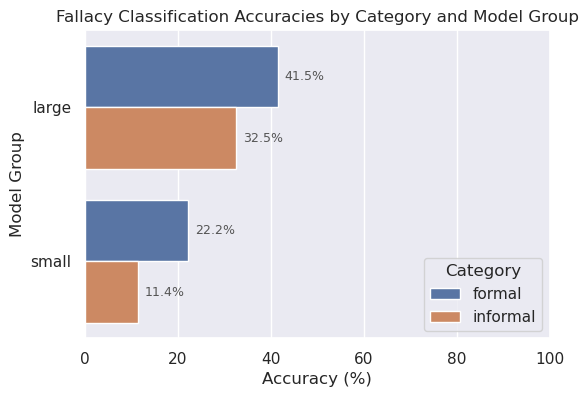

In [117]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Fallacy Classification Accuracies by Category and Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='category',
    legend_title='Category',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    annotate=True,
)

- In contrast to fallacy identification, classification accuracies are higher for formal fallacies.
- There are fewer formal fallacy types, which might make them easier to classify (dataset imbalance).
- Flagship LLMs outperform lightweight LLMs substantially.

### Subcategory Accuracies

In [118]:
df_subcategory_accuracies_e4.round(1)

category                   formal                                             \
subcategory         probabilistic propositional quantificational syllogistic   
gpt_4o                       57.5          65.0             50.0        38.8   
gpt_4o_mini                  60.0          48.3              1.7        22.5   
claude_3_5_sonnet            37.5          75.0             26.7        47.5   
claude_3_haiku               20.0          36.7              0.0         7.5   
gemini_1_5_pro               67.5          55.0             31.7        25.0   
gemini_1_5_flash_8b          27.5          45.0             15.0        16.2   
mistral_large_2              55.0          46.7              0.0        17.5   
mistral_small_2              37.5          30.0              3.3         7.5   
llama_3_1_70b                62.5          55.0              3.3        12.5   
llama_3_1_8b                 30.0          26.7              0.0         8.8   

category             informal                                          \
subcategory         ambiguity inappropriate presumption inconsistency   
gpt_4o                   44.0                      39.8          46.7   
gpt_4o_mini              19.3                      11.3           3.3   
claude_3_5_sonnet        42.0                      28.1          40.0   
claude_3_haiku           15.3                      11.1          16.7   
gemini_1_5_pro           46.0                      30.7          40.0   
gemini_1_5_flash_8b      18.0                      15.6           0.0   
mistral_large_2          27.3                      19.6           6.7   
mistral_small_2           4.7                       7.4           3.3   
llama_3_1_70b            28.7                      16.7          16.7   
llama_3_1_8b              8.0                       3.7           0.0   

category                                       
subcategory         insufficiency irrelevance  
gpt_4o                       36.0        42.1  
gpt_4o_mini                  17.9        24.1  
claude_3_5_sonnet            33.4        43.6  
claude_3_haiku               16.9        17.7  
gemini_1_5_pro               33.6        40.6  
gemini_1_5_flash_8b          11.2        13.6  
mistral_large_2              24.0        31.4  
mistral_small_2              12.6        17.7  
llama_3_1_70b                28.6        26.8  
llama_3_1_8b                  6.4        10.3

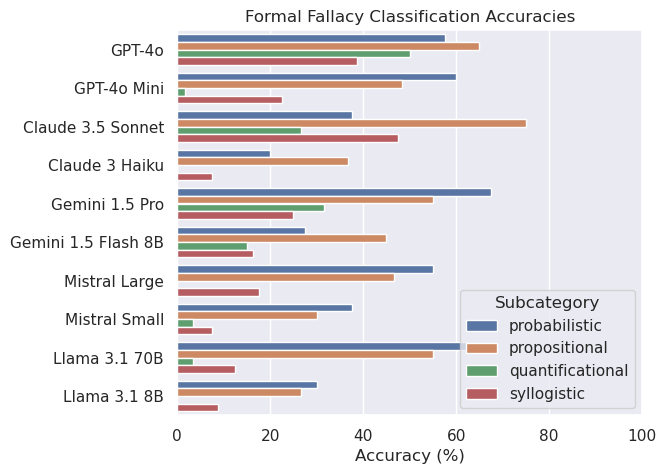

In [119]:
df_subcategory_accuracies_long_e4 = pd.melt(df_subcategory_accuracies_e4, value_name='accuracy', ignore_index=False)
df_formal_accuracies_long_e4 = df_subcategory_accuracies_long_e4[
    df_subcategory_accuracies_long_e4['category'] == 'formal']

plot_accuracies(
    data=add_llm_info(df_formal_accuracies_long_e4),
    figsize=(6, 5),
    title='Formal Fallacy Classification Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    annotate=False,
)

In [120]:
df_plot = add_llm_info(df_formal_accuracies_long_e4, group=True).groupby(
    ['llm_group', 'category', 'subcategory'], observed=True).mean().reset_index()
df_plot.round(1)

,llm_group,category,subcategory,accuracy
0,large,formal,probabilistic,56.0
1,large,formal,propositional,59.3
2,large,formal,quantificational,22.3
3,large,formal,syllogistic,28.2
4,small,formal,probabilistic,35.0
5,small,formal,propositional,37.3
6,small,formal,quantificational,4.0
7,small,formal,syllogistic,12.5


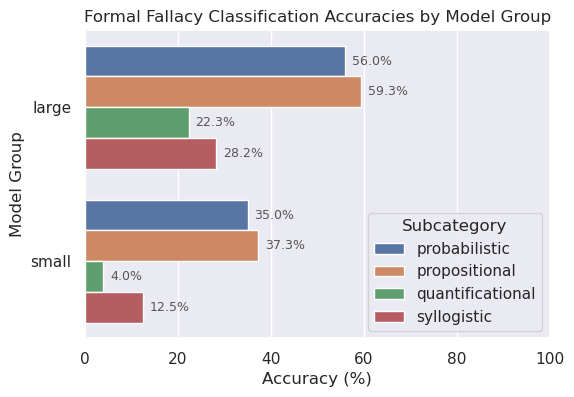

In [121]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Formal Fallacy Classification Accuracies by Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='subcategory',
    legend_title='Subcategory',
    annotate=True,
)

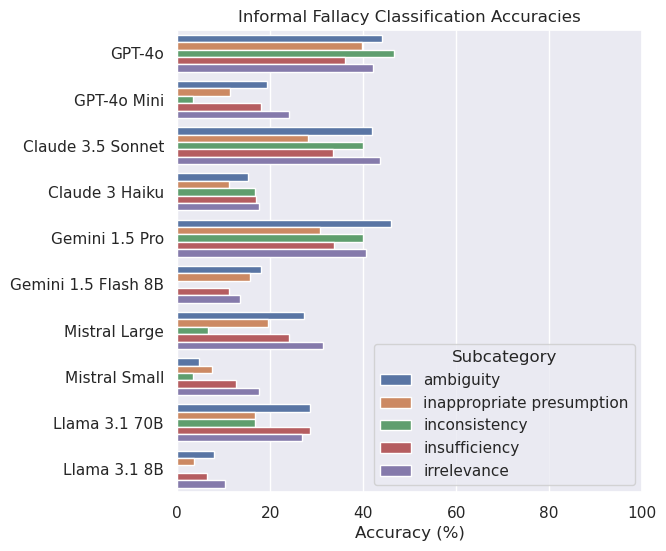

In [122]:
df_informal_accuracies_long_e4 = df_subcategory_accuracies_long_e4[
    df_subcategory_accuracies_long_e4['category'] == 'informal']

plot_accuracies(
    data=add_llm_info(df_informal_accuracies_long_e4),
    figsize=(6, 6),
    title='Informal Fallacy Classification Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    annotate=False,
)

In [123]:
df_plot = add_llm_info(df_informal_accuracies_long_e4, group=True).groupby(
    ['llm_group', 'category', 'subcategory'], observed=True).mean().reset_index()
df_plot

,llm_group,category,subcategory,accuracy
0,large,informal,ambiguity,37.6
1,large,informal,inappropriate presumption,27.0
2,large,informal,inconsistency,30.0
3,large,informal,insufficiency,31.137931
4,large,informal,irrelevance,36.897436
5,small,informal,ambiguity,13.066667
6,small,informal,inappropriate presumption,9.814815
7,small,informal,inconsistency,4.666667
8,small,informal,insufficiency,13.0
9,small,informal,irrelevance,16.666667


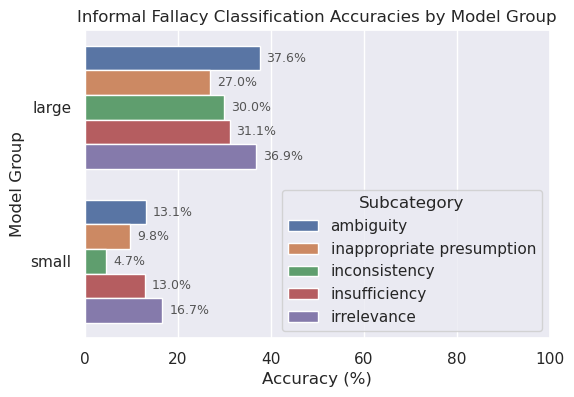

In [124]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Informal Fallacy Classification Accuracies by Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    annotate=True,
)

### Fallacy Confusion Metrics

In [125]:
df_confusion_matrices_e4 = get_confusion_matrices(df_fallacies_e4, 'fallacy')
df_fallacy_confusion_matrix_e4 = df_confusion_matrices_e4.groupby(['fallacy'], observed=True).sum()

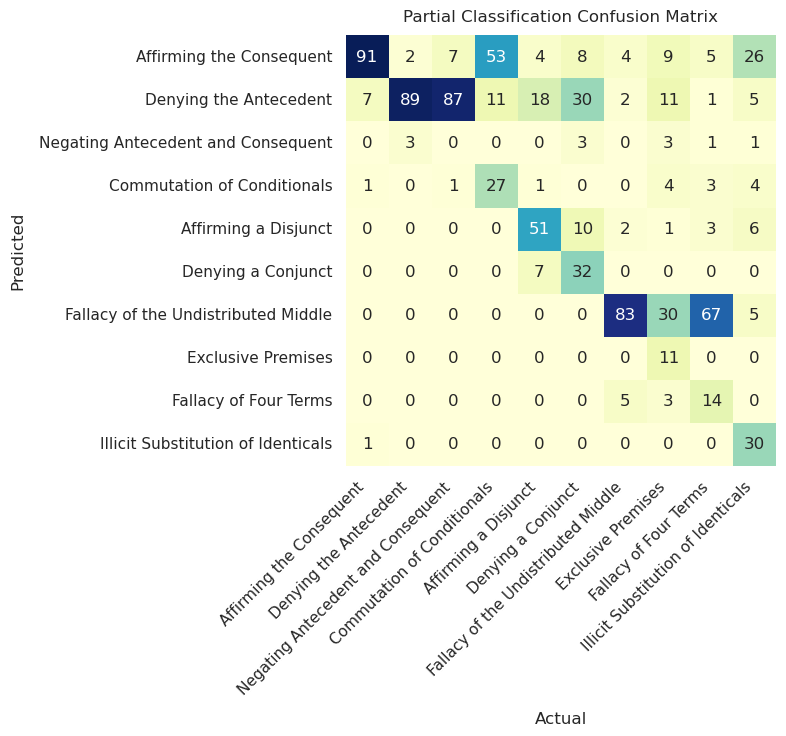

In [126]:
plot_classification_confusion_matrix(
    df_fallacy_confusion_matrix_e4.iloc[:10, :10],
    title='Partial Classification Confusion Matrix',
    figsize=(8, 8),
)

In [127]:
df_fallacy_confusion_metrics_e4 = get_confusion_metrics(df_fallacy_confusion_matrix_e4)
df_fallacy_confusion_metrics_e4.sort_values('recall', ascending=True).round(3)

,tp,tn,fp,fn,accuracy,precision,recall,f1,p_mcnemar
Alleged Certainty,0,22194,2,97,0.996,0.000,0.000,0.000,0.000
Shoehorning,0,22203,1,89,0.996,0.000,0.000,0.000,0.000
Subverted Support,0,22195,1,97,0.996,0.000,0.000,0.000,0.000
Fantasy Projection,0,22215,0,78,0.997,0.000,0.000,0.000,0.000
Post Designation,0,22153,43,97,0.994,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...
Denying the Antecedent,89,21651,544,9,0.975,0.141,0.908,0.244,0.000
Affirming the Consequent,91,20658,1535,9,0.931,0.056,0.910,0.105,0.000
Appeal to Tradition,91,22059,134,9,0.994,0.404,0.910,0.560,0.000
Sunk Cost Fallacy,93,22167,26,7,0.999,0.782,0.930,0.849,0.001


- By ordering the confusion metrics by recall (sensitiviy), we can identify fallacies which are most often missed.

In [128]:
df_fallacy_confusion_metrics_e4.sort_values('fp', ascending=False).round(3)

,tp,tn,fp,fn,accuracy,precision,recall,f1,p_mcnemar
Affirming the Consequent,91,20658,1535,9,0.931,0.056,0.910,0.105,0.0
Hasty Generalization,79,21096,1097,21,0.950,0.067,0.790,0.124,0.0
Appeal to Authority,89,21136,1057,11,0.952,0.078,0.890,0.143,0.0
Fallacy of Composition,68,21284,910,31,0.958,0.070,0.687,0.126,0.0
Fallacy of the Undistributed Middle,83,21544,649,17,0.970,0.113,0.830,0.200,0.0
...,...,...,...,...,...,...,...,...,...
Inflation of Conflict,13,22199,0,81,0.996,1.000,0.138,0.243,0.0
Proving Non Existence,0,22196,0,97,0.996,0.000,0.000,0.000,0.0
Self Righteousness Fallacy,0,22196,0,97,0.996,0.000,0.000,0.000,0.0
Amazing Familiarity,0,22195,0,98,0.996,0.000,0.000,0.000,0.0


- By ordering the confusion metrics by false positives, we can identify fallacies which are often predicted but wrong.

In [129]:
# Number of fallacies that were never classified correctly
(df_fallacy_confusion_metrics_e4['tp'] == 0).sum()

45

In [130]:
# Number of fallacies that were misclassified more often than correctly classified
(df_fallacy_confusion_metrics_e4['recall'] < 0.5).sum()

186

### Common Fallacy Misclassifications

In [131]:
df_fallacy_misclassifications_e4 = get_misclassifications(df_fallacy_confusion_matrix_e4, n_misclassifications=3)
df_fallacy_misclassifications_e4 = df_fallacy_confusion_metrics_e4[['fn']].join(df_fallacy_misclassifications_e4) 
df_fallacy_misclassifications_e4 = add_taxonomy(df_fallacy_misclassifications_e4)
df_fallacy_misclassifications_e4.sort_values(['fn', 'count_1'], ascending=False).round(3)


,fn,misclassification_1,count_1,misclassification_2,count_2,misclassification_3,count_3,category,subcategory
Negating Antecedent and Consequent,100,Denying the Antecedent,87,Affirming the Consequent,7,Illicit Contraposition,5,formal,propositional
Appeal to Trust,100,Appeal to Authority,80,Argument from False Authority,8,Affirming the Consequent,2,informal,irrelevance
Argument to the Purse,100,Appeal to Authority,80,Appeal to False Authority,6,Affirming the Consequent,4,informal,irrelevance
Blind Authority Fallacy,100,Appeal to Authority,79,Argument from False Authority,12,Appeal to False Authority,9,informal,irrelevance
Righteousness Fallacy,100,Appeal to Authority,65,Affirming the Consequent,9,Argument from False Authority,5,informal,irrelevance
...,...,...,...,...,...,...,...,...,...
Affirming the Consequent,9,Denying the Antecedent,7,Illicit Substitution of Identicals,1,Commutation of Conditionals,1,formal,propositional
Denying the Antecedent,9,Illicit Contraposition,4,Negating Antecedent and Consequent,3,Affirming the Consequent,2,formal,propositional
Appeal to Tradition,9,Stolen Concept Fallacy,4,Type Token Fallacy,3,Fallacy of Composition,1,informal,irrelevance
Sunk Cost Fallacy,7,Appeal to Consequences,2,Nirvana Fallacy,2,Alternative Advance,1,informal,insufficiency


- Many different fallacies are often misclassified as Appeal to Authority, Argument from False Authority, Appeal to False Authority. These are too similar.

## Experiment 5: Fallacy Classification with Fine-Tuning

In [132]:
df_fallacies_e5 = get_fallacy_df('data/fallacies_e5.csv')

[2024-11-06 12:05:51] Loaded existing fallacy dataframe from data/fallacies_e5.csv.


### Scoring and Sanity Check

In [133]:
add_classification_scores(df_fallacies_e5)

# Check completeness of responses
df_fallacies_e5.replace(['', RESPONSE_ERROR], None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   step                                 1160 non-null   object  
 1   entity                               1160 non-null   object  
 2   fallacy                              1160 non-null   category
 3   label                                1160 non-null   category
 4   category                             1160 non-null   category
 5   subcategory                          1160 non-null   category
 6   tuning                               1160 non-null   object  
 7   gpt_4o_mini_classification_response  1160 non-null   object  
 8   gpt_4o_mini_classification_pred      1156 non-null   category
 9   gpt_4o_mini_classification_score     1160 non-null   UInt8   
dtypes: UInt8(1), category(5), object(4)
memory usage: 67.0+ KB


In [134]:
get_sanity_check(df_fallacies_e5)

,response_length_mean,missing_responses,invalid_predictions
gpt_4o_mini_classification,19.2,0,4


In [135]:
df_confusion_matrices_e5 = get_confusion_matrices(df_fallacies_e5, 'fallacy')

In [136]:
# Answers from classification (experiment 4) will be compared with fine-tuned models.
df_fallacies_e5 = df_fallacies_e5.merge(
    df_fallacies_e4.drop(columns=['step', 'category', 'subcategory']),
    on=['entity', 'fallacy']
)

### Overall Accuracies

In [137]:
_, df_subcategory_accuracies_e5, df_category_accuracies_e5, df_overall_accuracies_e5 = get_macro_accuracies(df_fallacies_e5)

In [138]:
df_overall_accuracies_e5 = df_overall_accuracies_e5.sort_values('accuracy', ascending=False)
df_overall_accuracies_e5.round(1)

,accuracy
gpt_4o_mini_classification,78.1
gpt_4o,47.1
claude_3_5_sonnet,41.5
gemini_1_5_pro,40.6
llama_3_1_70b,26.6
mistral_large_2,24.7
gpt_4o_mini,24.0
gemini_1_5_flash_8b,18.3
claude_3_haiku,15.2
mistral_small_2,14.4


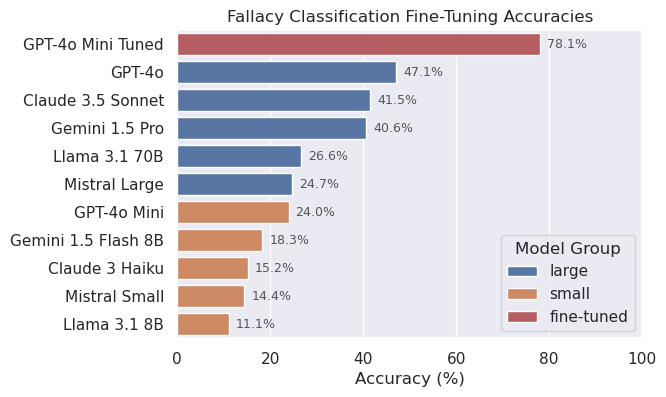

In [139]:
plot_accuracies(
    data=add_llm_info(df_overall_accuracies_e5),
    figsize=(6, 4),
    title='Fallacy Classification Fine-Tuning Accuracies',
    hue='llm_group',
    legend_title='Model Group',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    annotate=True,
)

- Fine-tuning leads to massive increases in classification accuracy.
- The fine-tuned GPT-4o Mini outperforms even the flagship GPT-4o model by a substantial amount.
- Accuracies differ slightly compared to experiment 4, they are calculated for the fine-tuning test set.

### Fallacy Category Accuracies

In [140]:
df_category_accuracies_e5

category,formal,informal
gpt_4o_mini_classification,92.5,63.685942
gpt_4o,54.375,39.850987
gpt_4o_mini,31.458333,16.446056
claude_3_5_sonnet,47.083333,35.832636
claude_3_haiku,15.208333,15.224364
gemini_1_5_pro,42.916667,38.373907
gemini_1_5_flash_8b,23.958333,12.650201
mistral_large_2,29.166667,20.315905
mistral_small_2,18.958333,9.941448
llama_3_1_70b,31.458333,21.684134


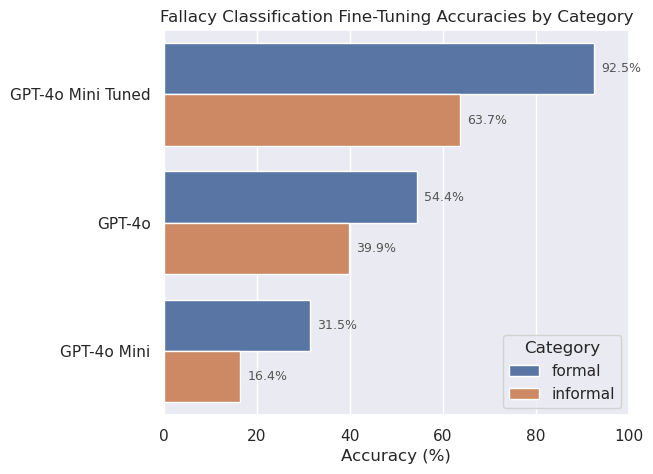

In [141]:
df_category_accuracies_long_e5 = pd.melt(df_category_accuracies_e5, var_name='category', value_name='accuracy',
                                         ignore_index=False)
plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e5),
    figsize=(6, 5),
    title='Fallacy Classification Fine-Tuning Accuracies by Category',
    hue='category',
    legend_title='Category',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    order=[llm.label for llm in [LLM.GPT_4O_MINI_CLASSIFICATION, LLM.GPT_4O, LLM.GPT_4O_MINI]],
    annotate=True,
)

- Fine-tuning increases classification accuracies both for formal and informal fallacies.
- Better classification accuracies for formal fallacies with and without fine-tuning.
- Accuracies differ slightly compared to experiment 4, they are calculated for the fine-tuning test set.

### Fallacy Subcategory Accuracies

In [142]:
df_subcategory_accuracies_e5.round(1)

category                          formal                                 \
subcategory                probabilistic propositional quantificational   
gpt_4o_mini_classification         100.0          96.7             83.3   
gpt_4o                              65.0          63.3             46.7   
gpt_4o_mini                         60.0          43.3              0.0   
claude_3_5_sonnet                   35.0          80.0             23.3   
claude_3_haiku                      25.0          33.3              0.0   
gemini_1_5_pro                      70.0          50.0             26.7   
gemini_1_5_flash_8b                 30.0          43.3             10.0   
mistral_large_2                     50.0          46.7              0.0   
mistral_small_2                     35.0          30.0              3.3   
llama_3_1_70b                       60.0          50.0              3.3   
llama_3_1_8b                        30.0          26.7              0.0   

category                                informal                            \
subcategory                syllogistic ambiguity inappropriate presumption   
gpt_4o_mini_classification        90.0      57.3                      73.3   
gpt_4o                            42.5      44.0                      38.9   
gpt_4o_mini                       22.5      21.3                      11.9   
claude_3_5_sonnet                 50.0      41.3                      28.1   
claude_3_haiku                     2.5      16.0                      10.7   
gemini_1_5_pro                    25.0      46.7                      31.9   
gemini_1_5_flash_8b               12.5      21.3                      17.0   
mistral_large_2                   20.0      25.3                      18.5   
mistral_small_2                    7.5       6.7                       7.0   
llama_3_1_70b                     12.5      29.3                      17.4   
llama_3_1_8b                       7.5       9.3                       4.1   

category                                                            
subcategory                inconsistency insufficiency irrelevance  
gpt_4o_mini_classification          40.0          68.3        79.5  
gpt_4o                              40.0          34.8        41.5  
gpt_4o_mini                          6.7          18.3        24.1  
claude_3_5_sonnet                   33.3          32.8        43.6  
claude_3_haiku                      13.3          17.6        18.5  
gemini_1_5_pro                      40.0          32.1        41.3  
gemini_1_5_flash_8b                  0.0          11.0        13.8  
mistral_large_2                      0.0          24.1        33.6  
mistral_small_2                      6.7          12.4        16.9  
llama_3_1_70b                        6.7          26.6        28.5  
llama_3_1_8b                         0.0           6.9        10.8

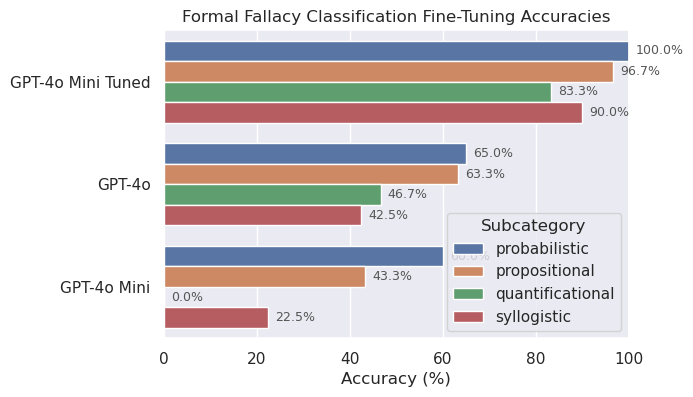

In [143]:
df_subcategory_accuracies_long_e5 = pd.melt(df_subcategory_accuracies_e5, value_name='accuracy', ignore_index=False)
df_formal_accuracies_long_e5 = df_subcategory_accuracies_long_e5[
    df_subcategory_accuracies_long_e5['category'] == 'formal']

plot_accuracies(
    data=add_llm_info(df_formal_accuracies_long_e5),
    figsize=(6, 4),
    title='Formal Fallacy Classification Fine-Tuning Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    order=[llm.label for llm in [LLM.GPT_4O_MINI_CLASSIFICATION, LLM.GPT_4O, LLM.GPT_4O_MINI]],
    annotate=True,
)

- Fine-tuning seems to eliminate weaknesses for specific subcategories, e.g. for quantificational and syllogistic fallacies.
- Accuracies differ slightly compared to experiment 4, they are calculated for the fine-tuning test set.

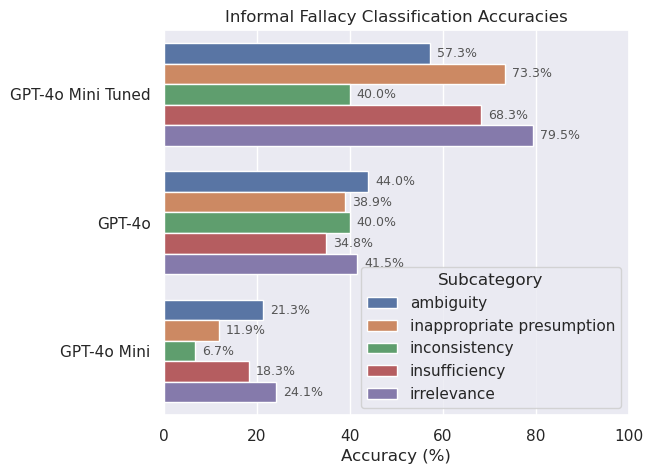

In [144]:
df_informal_accuracies_long_e5 = df_subcategory_accuracies_long_e5[
    df_subcategory_accuracies_long_e5['category'] == 'informal']

plot_accuracies(
    data=add_llm_info(df_informal_accuracies_long_e5),
    figsize=(6, 5),
    title='Informal Fallacy Classification Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    order=[llm.label for llm in [LLM.GPT_4O_MINI_CLASSIFICATION, LLM.GPT_4O, LLM.GPT_4O_MINI]],
    annotate=True,
)

### Common Fallacy Misclassifications

In [145]:
df_confusion_matrix_e5 = df_confusion_matrices_e5.groupby(['llm', 'fallacy'], observed=True).sum().loc[LLM.GPT_4O_MINI_CLASSIFICATION.key]
df_fallacy_confusion_metrics_e5 = get_confusion_metrics(df_confusion_matrix_e5)

In [146]:
df_fallacy_misclassifications_e5 = get_misclassifications(df_confusion_matrix_e5)
df_fallacy_misclassifications_e5 = df_fallacy_confusion_metrics_e5[['fn']].join(df_fallacy_misclassifications_e5) 
df_fallacy_misclassifications_e5 = add_taxonomy(df_fallacy_misclassifications_e5)
df_fallacy_misclassifications_e5.sort_values(['fn', 'count_1'], ascending=False).round(3)

,fn,misclassification_1,count_1,misclassification_2,count_2,misclassification_3,count_3,category,subcategory
Argument by Fast Talking,5,Two Wrongs Make a Right,4,Hypothesis Contrary to Fact,1,,0,informal,irrelevance
Self Righteousness Fallacy,5,Righteousness Fallacy,4,Having Your Cake,1,,0,informal,irrelevance
Psychogenetic Fallacy,5,Genetic Fallacy,4,Bulverism,1,,0,informal,insufficiency
Selective Attention,5,Overwhelming Exception,3,Appeal to Closure,1,Overextended Outrage,1,informal,insufficiency
Texas Sharpshooter Fallacy,5,Weak Analogy,3,False Equivalence,1,Faulty Comparison,1,informal,insufficiency
...,...,...,...,...,...,...,...,...,...
Appeal to Self evident Truth,0,,0,,0,,0,informal,inappropriate presumption
Double Standard,0,,0,,0,,0,informal,inappropriate presumption
Argument to Moderation,0,,0,,0,,0,informal,inappropriate presumption
Broken Window Fallacy,0,,0,,0,,0,informal,inappropriate presumption


- Fine tuning results are much better, but some fallacies are still often misclassified.